In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#import python classes and packages
from string import punctuation
#importing NLP packages for text review processing
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import pickle
from nltk.stem import PorterStemmer
from keras.utils.np_utils import to_categorical
import os
from sklearn.metrics import accuracy_score
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential, Model, load_model
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint 
from keras.layers import Bidirectional, GRU, LSTM, Conv1D, MaxPooling1D, RepeatVector#loading GRU, bidriectional, lstm and CNN
from sentence_transformers import SentenceTransformer #loading bert sentence model
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
#create bert model object
bert = SentenceTransformer('nli-distilroberta-base-v2')
print("Bert model initialized")

Bert model initialized


In [4]:
#defining classes to remove stop words, applying steeming and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

In [5]:
#define function to clean text reviews from dataset
def cleanText(doc):
    tokens = doc.split()
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    tokens = [ps.stem(token) for token in tokens]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = ' '.join(tokens)
    return tokens

In [5]:
#load and display Novelty Seeking reviews dataset
dataset = pd.read_csv("Dataset/processed.csv")
dataset

,content,label,type
0,Wow what an amazing walk on the Great Wall of ...,0,train
1,I came to spend 2 hours between 2 professional...,0,train
2,A MUST visit in one's life. History and Art fr...,1,train
3,"It's was very peaceful and beautiful, go with ...",0,train
4,It is beautiful lake in all seasons. Beautiful...,0,train
...,...,...,...
3995,I visited it right when the official change to...,0,valid
3996,Suomenlinna is stunning historic place. We wen...,1,valid
3997,"Milcha/Mike was funny, really knowledgeable an...",1,valid
3998,From the Helsinki market place there is a ferr...,1,valid


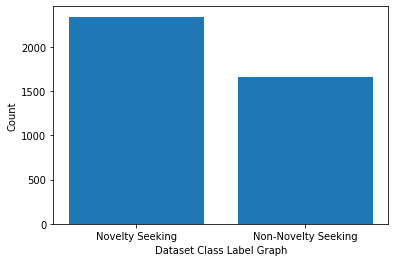

In [7]:
#find and plot graph of Novelty Seeking from dataset where 0 label refers as review contains Novelty Seeking and 1 as
#non-novelty seeking
#plot labels in dataset
labels, count = np.unique(dataset['label'], return_counts = True)
labels = ['Novelty Seeking', 'Non-Novelty Seeking']
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.show()

In [8]:
#now clean dataset reviews and then convert to BERT vector
if os.path.exists("model/bert.npy"):
    X = np.load("model/bert.npy")
    Y = np.load("model/label.npy")
else:
    textdata = []
    labels = []
    for i in range(len(dataset)):#loop all reviews from dataset
        msg = dataset.get_value(i, 'content')#read review content
        label = dataset.get_value(i, 'label')#read label
        msg = msg.strip().lower()      #convert text to lower case  
        msg = cleanPost(msg)#clean the review message
        textdata.append(msg)#add message to textdata array    
        labels.append(label)#adding label to array
    embeddings = bert.encode(textdata, convert_to_tensor=True)#convert all text data into BERT vector
    X = embeddings.numpy()#convert bert vector into numpy for training
    np.save("model/bert", X)#save bert data and labels to model folder
    Y = np.asarray(labels)
    np.save("model/label", Y)
print("Bert Converted Embedding vector from dataset reviews")
print(X)

Bert Converted Embedding vector from dataset reviews
[[-0.04793587  0.5640375  -0.6450349  ... -0.65913534  0.9045596
   0.5499603 ]
 [ 0.70733136 -0.08709043  0.07673962 ... -0.32128632  0.6108363
   0.01826572]
 [-0.48672682  0.44718155 -0.50237244 ...  0.08478663  0.78687054
   0.23511195]
 ...
 [ 0.26772055  0.76312727 -0.02005892 ...  0.51458335  0.05910476
   0.42454597]
 [ 0.33064586  0.3962934   0.22244608 ... -0.4317711   0.66906726
   0.24422391]
 [ 0.8522946   0.74757236  0.3078637  ... -0.13496889  0.6102617
   0.81993985]]


In [9]:
#perform dataset preprocessing such as shuffling and splitting dataset into train and test where application used 80% dataset
#for training and 20% for testing
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
X = np.reshape(X, (X.shape[0], 32, 24))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Testing Size (20%): "+str(X_test.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 3200
Testing Size (20%): 800



In [6]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

ML_Model = []
acc = []
prec = []
rec = []
f1 = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    acc.append(round(a, 3))
    prec.append(round(b, 3))
    rec.append(round(c, 3))
    f1.append(round(d, 3))

In [97]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100     
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

# LSTM

In [13]:
#now train existing BERT-LSTM algorithm
lstm = Sequential() #defining deep learning sequential object
#adding GRU layer with 32 filters to filter given input X train data to select relevant features
lstm.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
#adding dropout layer to remove irrelevant features
lstm.add(Dropout(0.3))
#adding another layer
lstm.add(LSTM(32))
lstm.add(Dropout(0.3))
#defining output layer for prediction
lstm.add(Dense(y_train.shape[1], activation='softmax'))
#compile GRU model
lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#start training model on train data and perform validation on test data
#if os.path.exists("model/lstm_weights.hdf5") == False:
    #model_check_point = ModelCheckpoint(filepath='model/lstm_weights.hdf5', verbose = 1, save_best_only = True)
hist = lstm.fit(X_train, y_train, batch_size = 16, epochs = 35, validation_data=(X_test, y_test), verbose=1)
    #f = open('model/lstm_history.pckl', 'wb')
    #pickle.dump(hist.history, f)
    #f.close() 
#else:
    #lstm = load_model("model/lstm_weights.hdf5")


Epoch 1/35
200/200 [==============================] - 17s 13ms/step - loss: 0.6794 - accuracy: 0.5781 - val_loss: 0.6456 - val_accuracy: 0.6425
Epoch 2/35
200/200 [==============================] - 2s 8ms/step - loss: 0.6499 - accuracy: 0.6243 - val_loss: 0.6220 - val_accuracy: 0.6525
Epoch 3/35
200/200 [==============================] - 2s 9ms/step - loss: 0.6133 - accuracy: 0.6626 - val_loss: 0.5971 - val_accuracy: 0.7063
Epoch 4/35
200/200 [==============================] - 2s 9ms/step - loss: 0.5966 - accuracy: 0.6829 - val_loss: 0.5743 - val_accuracy: 0.7050
Epoch 5/35
200/200 [==============================] - 2s 9ms/step - loss: 0.5584 - accuracy: 0.7219 - val_loss: 0.5737 - val_accuracy: 0.6862
Epoch 6/35
200/200 [==============================] - 2s 9ms/step - loss: 0.5380 - accuracy: 0.7276 - val_loss: 0.5707 - val_accuracy: 0.7150
Epoch 7/35
200/200 [==============================] - 2s 8ms/step - loss: 0.5222 - accuracy: 0.7450 - val_loss: 0.5646 - val_accuracy: 0.7075
Epoc

In [7]:
blstm_acc = (accuracy_score(predict, target))
blstm_prec = precision_score(predict, target,average='weighted')
blstm_rec = recall_score(predict, target,average='weighted')
blstm_f1 = f1_score(predict, target,average='weighted')

In [8]:
storeResults('Existing BERT-LSTM Model',blstm_acc,blstm_prec,blstm_rec,blstm_f1)

# BiGRU

In [18]:
#now train propose BERT-BiGRU algorithm
gru_bilstm = Sequential() #defining deep learning sequential object
#adding GRU layer with 32 filters to filter given input X train data to select relevant features
gru_bilstm.add(Bidirectional(GRU(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)))
#adding dropout layer to remove irrelevant features
gru_bilstm.add(Dropout(0.3))
#adding another layer
gru_bilstm.add(Bidirectional(GRU(32)))#adding bidirectional-GRU layer and peform training on X_train Bert data
gru_bilstm.add(Dropout(0.3))
#defining output layer for prediction
gru_bilstm.add(Dense(y_train.shape[1], activation='softmax'))
#compile GRU model
gru_bilstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#start training model on train data and perform validation on test data
#if os.path.exists("model/bigru_weights.hdf5") == False:
    #model_check_point = ModelCheckpoint(filepath='model/bigru_weights.hdf5', verbose = 1, save_best_only = True)
hist = gru_bilstm.fit(X_train, y_train, batch_size = 16, epochs = 35, validation_data=(X_test, y_test), verbose=1)
    #f = open('model/bigru_history.pckl', 'wb')
    #pickle.dump(hist.history, f)
    #f.close() 
#else:
    #gru_bilstm = load_model("model/bigru_weights.hdf5")


Epoch 1/35
200/200 [==============================] - 13s 15ms/step - loss: 0.6659 - accuracy: 0.5801 - val_loss: 0.6187 - val_accuracy: 0.6612
Epoch 2/35
200/200 [==============================] - 2s 9ms/step - loss: 0.6098 - accuracy: 0.6778 - val_loss: 0.5951 - val_accuracy: 0.6938
Epoch 3/35
200/200 [==============================] - 2s 9ms/step - loss: 0.5978 - accuracy: 0.6673 - val_loss: 0.5758 - val_accuracy: 0.7125
Epoch 4/35
200/200 [==============================] - 2s 9ms/step - loss: 0.5628 - accuracy: 0.7004 - val_loss: 0.5686 - val_accuracy: 0.7050
Epoch 5/35
200/200 [==============================] - 2s 9ms/step - loss: 0.5524 - accuracy: 0.7182 - val_loss: 0.5819 - val_accuracy: 0.6888
Epoch 6/35
200/200 [==============================] - 2s 9ms/step - loss: 0.5331 - accuracy: 0.7200 - val_loss: 0.5507 - val_accuracy: 0.7262
Epoch 7/35
200/200 [==============================] - 2s 9ms/step - loss: 0.5152 - accuracy: 0.7358 - val_loss: 0.5645 - val_accuracy: 0.7038
Epoc

In [9]:
blstm_acc = (accuracy_score(predict, target))
blstm_prec = precision_score(predict, target,average='weighted')
blstm_rec = recall_score(predict, target,average='weighted')
blstm_f1 = f1_score(predict, target,average='weighted')

In [10]:
storeResults('Propose BERT-Bi-GRU Model',blstm_acc,blstm_prec,blstm_rec,blstm_f1)

# Extension BERT-CNN-Bi-GRU Model

In [23]:
#now define extension model by combining two different models called BERT + CNN + BiGRU models as this CNN + bi-lstm will 
#optimized features from both forward and backward direction so it will have more optimzied features and accuracy will be better
extension_model = Sequential()
#defining CNN layer
extension_model.add(Conv1D(filters=32, kernel_size = 15, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))
extension_model.add(Conv1D(filters=16, kernel_size = 12, activation = 'relu'))
#adding maxpool layer
extension_model.add(MaxPooling1D(pool_size = 2))
extension_model.add(Dropout(0.3))
extension_model.add(Flatten())
extension_model.add(RepeatVector(2))
#adding bidirectional + GRU to CNN layer
extension_model.add(Bidirectional(GRU(24, activation = 'relu')))
extension_model.add(Dropout(0.3))
#defining output layer
extension_model.add(Dense(units = 33, activation = 'softmax'))
extension_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compile and train the model
extension_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#if os.path.exists("model/extension_weights.hdf5") == False:
    #model_check_point = ModelCheckpoint(filepath='model/extension_weights.hdf5', verbose = 1, save_best_only = True)
hist = extension_model.fit(X_train, y_train, batch_size = 16, epochs = 35, validation_data=(X_test, y_test), verbose=1)
    #f = open('model/extension_history.pckl', 'wb')
    #pickle.dump(hist.history, f)
    #f.close()    
#else:
    #extension_model = load_model("model/extension_weights.hdf5")
#perform prediction on test data using bidirectional LSTM on test data   

Epoch 1/35
200/200 [==============================] - 10s 16ms/step - loss: 0.6786 - accuracy: 0.5729 - val_loss: 0.6335 - val_accuracy: 0.6650
Epoch 2/35
200/200 [==============================] - 3s 13ms/step - loss: 0.6335 - accuracy: 0.6635 - val_loss: 0.6073 - val_accuracy: 0.6925
Epoch 3/35
200/200 [==============================] - 3s 13ms/step - loss: 0.5999 - accuracy: 0.6977 - val_loss: 0.6055 - val_accuracy: 0.6750
Epoch 4/35
200/200 [==============================] - 3s 13ms/step - loss: 0.5609 - accuracy: 0.7376 - val_loss: 0.5881 - val_accuracy: 0.6938
Epoch 5/35
200/200 [==============================] - 3s 13ms/step - loss: 0.5478 - accuracy: 0.7366 - val_loss: 0.6069 - val_accuracy: 0.6938
Epoch 6/35
200/200 [==============================] - 3s 13ms/step - loss: 0.5036 - accuracy: 0.7786 - val_loss: 0.6125 - val_accuracy: 0.6963
Epoch 7/35
200/200 [==============================] - 3s 13ms/step - loss: 0.4733 - accuracy: 0.8080 - val_loss: 0.5720 - val_accuracy: 0.721

In [11]:
blstm_acc = (accuracy_score(predict, target))
blstm_prec = precision_score(predict, target,average='weighted')
blstm_rec = recall_score(predict, target,average='weighted')
blstm_f1 = f1_score(predict, target,average='weighted')



In [12]:
storeResults('Extension BERT-CNN-Bi-GRU Model',blstm_acc,blstm_prec,blstm_rec,blstm_f1)

# LSTM + GRU

In [26]:
#now train propose BERT-BiGRU algorithm
lstmgru = Sequential() #defining deep learning sequential object
#adding GRU layer with 32 filters to filter given input X train data to select relevant features
lstmgru.add(Bidirectional(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)))
#adding dropout layer to remove irrelevant features
lstmgru.add(Dropout(0.3))
#adding another layer
lstmgru.add(Bidirectional(GRU(32)))#adding bidirectional-GRU layer and peform training on X_train Bert data
lstmgru.add(Dropout(0.3))
#defining output layer for prediction
lstmgru.add(Dense(y_train.shape[1], activation='softmax'))
#compile GRU model
lstmgru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#start training model on train data and perform validation on test data
#if os.path.exists("model/bigru_weights.hdf5") == False:
    #model_check_point = ModelCheckpoint(filepath='model/bigru_weights.hdf5', verbose = 1, save_best_only = True)
hist = lstmgru.fit(X_train, y_train, batch_size = 2, epochs = 35, validation_data=(X_test, y_test), verbose=1)
    #f = open('model/bigru_history.pckl', 'wb')
    #pickle.dump(hist.history, f)
    #f.close() 
#else:
    #gru_bilstm = load_model("model/bigru_weights.hdf5")


Epoch 1/35
1600/1600 [==============================] - 19s 9ms/step - loss: 0.6614 - accuracy: 0.6029 - val_loss: 0.6004 - val_accuracy: 0.6862
Epoch 2/35
1600/1600 [==============================] - 13s 8ms/step - loss: 0.5890 - accuracy: 0.6834 - val_loss: 0.5980 - val_accuracy: 0.6850
Epoch 3/35
1600/1600 [==============================] - 13s 8ms/step - loss: 0.5583 - accuracy: 0.7158 - val_loss: 0.5555 - val_accuracy: 0.7250
Epoch 4/35
1600/1600 [==============================] - 13s 8ms/step - loss: 0.5329 - accuracy: 0.7330 - val_loss: 0.5514 - val_accuracy: 0.7250
Epoch 5/35
1600/1600 [==============================] - 13s 8ms/step - loss: 0.5223 - accuracy: 0.7384 - val_loss: 0.5530 - val_accuracy: 0.7212
Epoch 6/35
1600/1600 [==============================] - 13s 8ms/step - loss: 0.4780 - accuracy: 0.7762 - val_loss: 0.5471 - val_accuracy: 0.7225
Epoch 7/35
1600/1600 [==============================] - 13s 8ms/step - loss: 0.4457 - accuracy: 0.7942 - val_loss: 0.5479 - val_ac

In [13]:
blstm_acc = (accuracy_score(predict, target))
blstm_prec = precision_score(predict, target,average='weighted')
blstm_rec = recall_score(predict, target,average='weighted')
blstm_f1 = f1_score(predict, target,average='weighted')

storeResults('Extension BERT-LSTM-GRU Model',blstm_acc,blstm_prec,blstm_rec,blstm_f1)

# GRU

In [32]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
import os
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, callbacks
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Embedding

from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [15]:
import collections
import nltk
from sklearn import preprocessing
from nltk.tokenize import sent_tokenize, word_tokenize
from tensorflow.keras import regularizers

In [16]:
#Setting parameters which will be used throughout
num_words = 15000  # Parameter indicating the number of words we'll put in the dictionary
val_size = 1000  # Size of the validation set
#epochs = 20  # Number of epochs we usually start to train with
batch_size = 2  # Size of the batches used in the mini-batch gradient descent
#Taking only two columns since it's a sentiment analysis

In [39]:
#tweets conssits of every document as an array of tokenized words which are later appended to docs 
tweets=[word_tokenize(tweet) for tweet in dataset['content']]
docs=[]
for j in range(0,len(tweets)):
    docs.append(tweets[j])

In [40]:
#stops included both the stopwords and punctuations
from nltk.corpus import stopwords
import string
stops = set(stopwords.words('english'))
punctuations = list(string.punctuation)
not_list = ["n't", "not", "no"]
stops.update(punctuations)
stops.update(not_list)

In [41]:
#to get the simple pos(part of speech) tag
from nltk.corpus import wordnet
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [42]:
#to get the pos tag for a word
from nltk import pos_tag
# now we are going to clean our data 
# we will remove stopwords and punctuations and lemmatize each document
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
def clean(words):
    output=[]
    for word in words:
        if word.lower() not in stops or word.lower() in not_list:
            pos=pos_tag(word)
            clean_word=lemmatizer.lemmatize(word,pos=get_simple_pos(pos[0][1]))
            output.append(clean_word.lower())
    str1=" ".join(output).encode('utf-8')        
    return str1
#docs=[ clean(doc) for doc in docs]      

In [43]:
#taking variables to be used for train test split as X,y
X,Y=dataset['content'].values,pd.get_dummies(dataset['label'].values)

In [44]:
#using tokenizers to create the tokens having no of words=15000(num_words)
tk = Tokenizer(num_words=num_words,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
#Complete data is tokenized to vectors and padding is done using zeros to match its length to the largest text in the dataset.
tk.fit_on_texts(X)
X = tk.texts_to_sequences(X)
X = pad_sequences(X)
#print(X[:2])
print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 200 documents
15000 words in dictionary
Top 5 most common words are: [('the', 656), ('and', 370), ('to', 332), ('a', 285), ('of', 228)]


In [45]:
import pickle
pickle.dump(tk,open('transform.pkl','wb'))

In [50]:
#train test split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

In [47]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [59]:
embed_dim = 128 #dimension of the word embedding vector for each word in a sequence 
lstm_out = 196  #no of lstm layers
model = Sequential()
model.add(Embedding(num_words, embed_dim,input_length = X_train.shape[1]))
#Adding dropout
model.add(GRU(lstm_out, dropout=0.2, recurrent_dropout=0.2))
#Adding a regularized dense layer
model.add(layers.Dense(32,kernel_regularizer=regularizers.l2(0.001),activation='relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy',f1_m,precision_m, recall_m])

In [60]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 429, 128)          1920000   
_________________________________________________________________
gru_6 (GRU)                  (None, 196)               191688    
_________________________________________________________________
dense_8 (Dense)              (None, 32)                6304      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 2)                 66        
Total params: 2,118,058
Trainable params: 2,118,058
Non-trainable params: 0
_________________________________________________________________


In [61]:
#model trained on the training data and taking validation data into account to avoid overfitting for 4 epochs 
history = model.fit(X_train, Y_train, epochs = 35, batch_size=2,validation_data=(X_test, Y_test),verbose = 1)

Epoch 1/35
100/100 [==============================] - 60s 589ms/step - loss: 0.7307 - accuracy: 0.5450 - f1_m: 0.5450 - precision_m: 0.5450 - recall_m: 0.5450 - val_loss: 0.6936 - val_accuracy: 0.5550 - val_f1_m: 0.5550 - val_precision_m: 0.5550 - val_recall_m: 0.5550
Epoch 2/35
100/100 [==============================] - 59s 590ms/step - loss: 0.6747 - accuracy: 0.7050 - f1_m: 0.7050 - precision_m: 0.7050 - recall_m: 0.7050 - val_loss: 0.4844 - val_accuracy: 0.9550 - val_f1_m: 0.9550 - val_precision_m: 0.9550 - val_recall_m: 0.9550
Epoch 3/35
100/100 [==============================] - 58s 584ms/step - loss: 0.3193 - accuracy: 0.9100 - f1_m: 0.9100 - precision_m: 0.9100 - recall_m: 0.9100 - val_loss: 0.1270 - val_accuracy: 0.9850 - val_f1_m: 0.9850 - val_precision_m: 0.9850 - val_recall_m: 0.9850
Epoch 4/35
100/100 [==============================] - 62s 620ms/step - loss: 0.1470 - accuracy: 0.9750 - f1_m: 0.9750 - precision_m: 0.9750 - recall_m: 0.9750 - val_loss: 0.0375 - val_accuracy:

100/100 [==============================] - 60s 602ms/step - loss: 0.0033 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 32/35
100/100 [==============================] - 58s 585ms/step - loss: 0.0032 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 33/35
100/100 [==============================] - 58s 582ms/step - loss: 0.0032 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 34/35
100/100 [==============================] - 74s 741ms/step - loss: 0.0024 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000 

In [62]:
dl_acc = history.history['val_accuracy'][34]
dl_prec = history.history['val_precision_m'][34]
dl_rec = history.history['val_recall_m'][34]
dl_f1 = history.history['val_f1_m'][34]

storeResults('GRU',dl_acc,dl_prec,dl_rec,dl_f1)

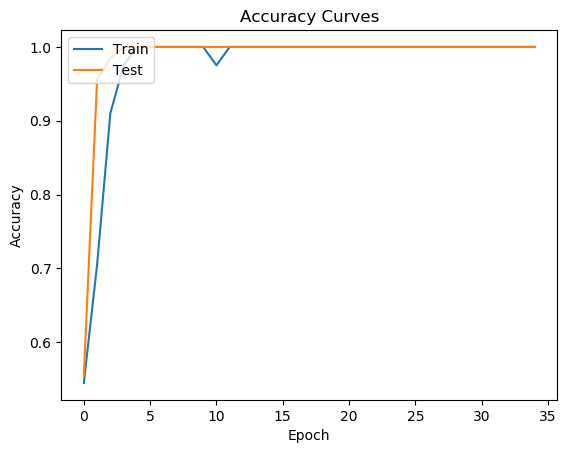

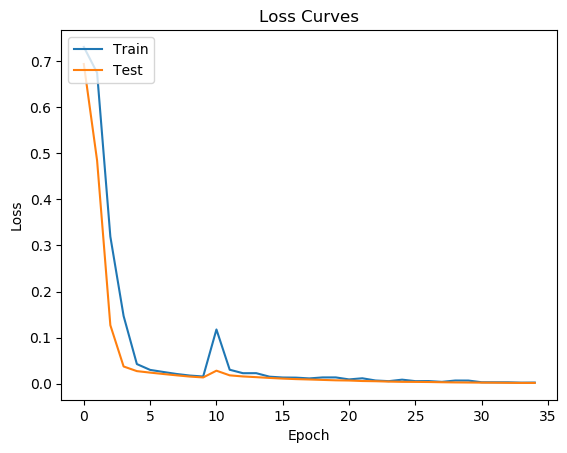

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# BiLSTM + GRU

In [64]:
model_hy=tf.keras.Sequential()

model_hy.add(tf.keras.layers.Input(shape=[100]))
model_hy.add(tf.keras.layers.Embedding(num_words,embed_dim,input_length=X_train.shape[1]))    

model_hy.add(Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True)))
model_hy.add(tf.keras.layers.Dropout(0.5))

model_hy.add(tf.keras.layers.LSTM(200,return_sequences=True))
model_hy.add(tf.keras.layers.Dropout(0.5))

model_hy.add(tf.keras.layers.GRU(200))
model_hy.add(tf.keras.layers.Dropout(0.5))
          
model_hy.add(tf.keras.layers.Dense(256))
model_hy.add(tf.keras.layers.Dropout(0.5))

model_hy.add(tf.keras.layers.Dense(2,activation='sigmoid')) #output layer

model_hy.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 128)          1920000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 400)          526400    
_________________________________________________________________
dropout_13 (Dropout)         (None, 100, 400)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 200)          480800    
_________________________________________________________________
dropout_14 (Dropout)         (None, 100, 200)          0         
_________________________________________________________________
gru_7 (GRU)                  (None, 200)               241200    
_________________________________________________________________
dropout_15 (Dropout)         (None, 200)              

In [65]:
model_hy.compile(loss='categorical_crossentropy',optimizer='adam',metrics = ['accuracy',f1_m,precision_m, recall_m])

In [66]:
#model trained on the training data and taking validation data into account to avoid overfitting for 4 epochs 
history1 = model_hy.fit(X_train, Y_train, epochs = 35, batch_size=2,validation_data=(X_test, Y_test),verbose = 1)

Epoch 1/35
100/100 [==============================] - 16s 103ms/step - loss: 0.7132 - accuracy: 0.4600 - f1_m: 0.5053 - precision_m: 0.4733 - recall_m: 0.5600 - val_loss: 0.6923 - val_accuracy: 0.5550 - val_f1_m: 0.5530 - val_precision_m: 0.5517 - val_recall_m: 0.5550
Epoch 2/35
100/100 [==============================] - 10s 96ms/step - loss: 0.6943 - accuracy: 0.5800 - f1_m: 0.6100 - precision_m: 0.5917 - recall_m: 0.6600 - val_loss: 0.4799 - val_accuracy: 0.8150 - val_f1_m: 0.8183 - val_precision_m: 0.8250 - val_recall_m: 0.8150
Epoch 3/35
100/100 [==============================] - 10s 96ms/step - loss: 0.4517 - accuracy: 0.8300 - f1_m: 0.8173 - precision_m: 0.8267 - recall_m: 0.8200 - val_loss: 0.1593 - val_accuracy: 0.9500 - val_f1_m: 0.9477 - val_precision_m: 0.9483 - val_recall_m: 0.9500
Epoch 4/35
100/100 [==============================] - 10s 98ms/step - loss: 0.0865 - accuracy: 0.9800 - f1_m: 0.9767 - precision_m: 0.9800 - recall_m: 0.9750 - val_loss: 0.0224 - val_accuracy: 0.

100/100 [==============================] - 10s 98ms/step - loss: 1.8185e-06 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 3.2723e-07 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 28/35
100/100 [==============================] - 10s 97ms/step - loss: 3.8804e-06 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 2.9683e-07 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 29/35
100/100 [==============================] - 10s 98ms/step - loss: 5.7047e-06 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 2.4021e-07 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 30/35
100/100 [==============================] - 10s 97ms/step - loss: 5.4982e-06 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 1.9670

In [68]:
dl_acc = history1.history['val_accuracy'][34]
dl_prec = history1.history['val_precision_m'][34]
dl_rec = history1.history['val_recall_m'][34]
dl_f1 = history1.history['val_f1_m'][34]

storeResults('BiLSTM+LSTM+GRU',dl_acc,dl_prec,dl_rec,dl_f1)

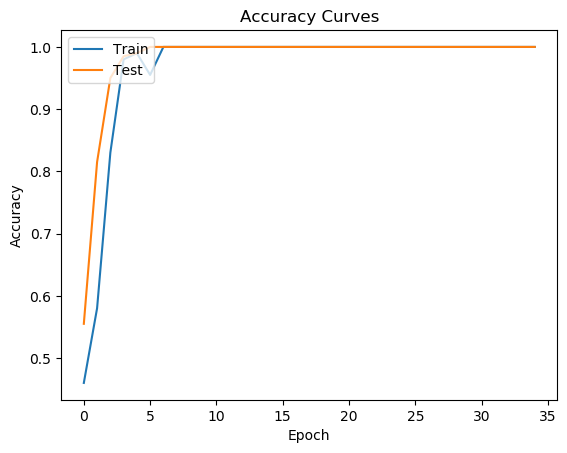

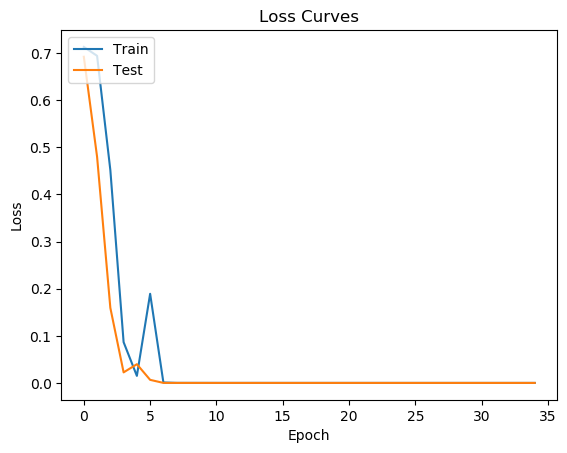

In [67]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Comparison

In [69]:
#creating dataframe
import pandas as pd
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : acc,
                       'Precision': prec,
                       'Recall'   : rec,
                        'f1_score' : f1,
                      })

In [70]:
result

,ML Model,Accuracy,Precision,Recall,f1_score
0,Existing BERT-LSTM Model,0.994,0.994,0.994,0.994
1,Propose BERT-Bi-GRU Model,0.995,0.995,0.995,0.995
2,Extension BERT-CNN-Bi-GRU Model,0.975,0.975,0.975,0.975
3,Extension BERT-LSTM-GRU Model,0.994,0.994,0.994,0.994
4,GRU,1.000,1.000,1.000,1.000
5,BiLSTM+LSTM+GRU,1.000,1.000,1.000,1.000


In [71]:
model_hy.save('model.h5')

# Graph

In [72]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

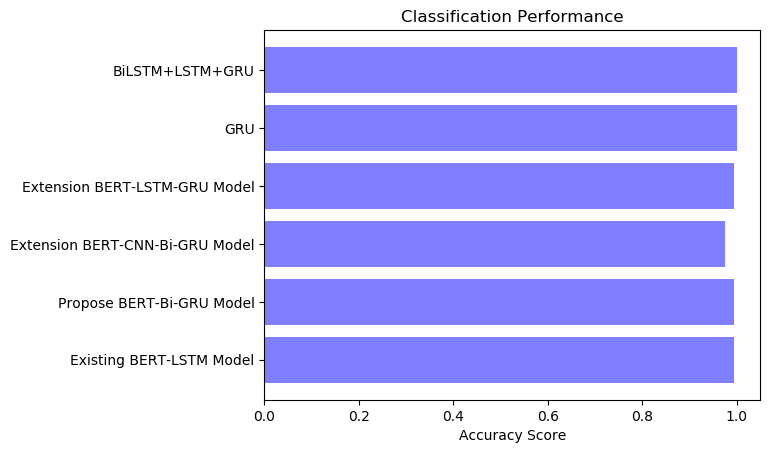

In [73]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, acc, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

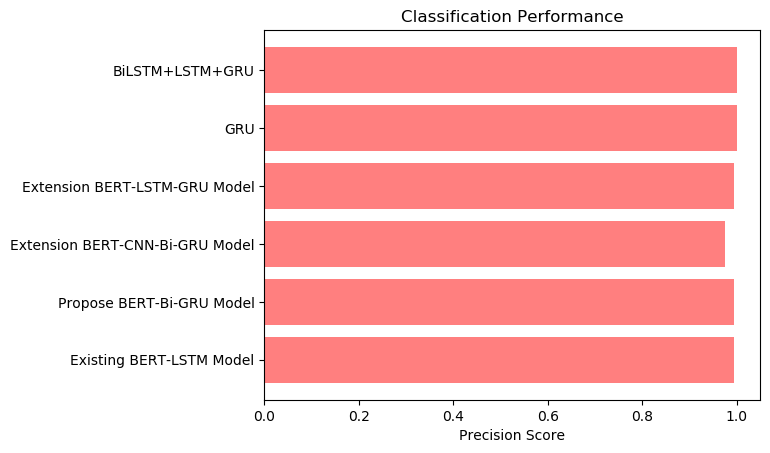

In [74]:
plt2.barh(y_pos, prec, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

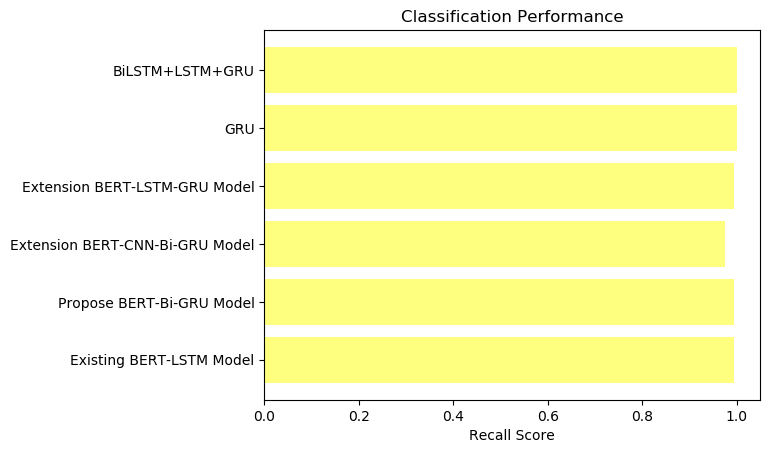

In [75]:
plt2.barh(y_pos, rec, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

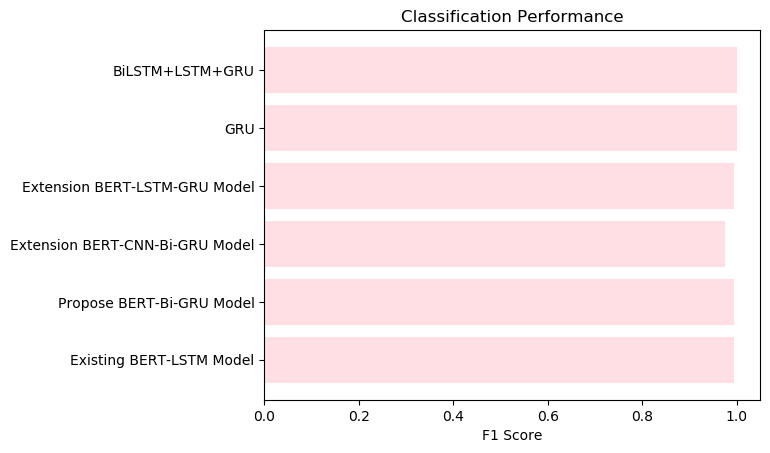

In [76]:
plt2.barh(y_pos, f1, align='center', alpha=0.5,color='pink')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()

# Prediction

In [89]:
labels = ['Novelty Seeking', 'Non-Novelty Seeking']

In [80]:
model = load_model('model.h5',compile=False)

cv=pickle.load(open('transform.pkl','rb'))

In [91]:
msg = 'Wow what an amazing walk on the Great Wall of China, amazing view from each look out points along the wall, November weather was fantastic while we were there.'

In [92]:
data = [msg]
vect = cv.texts_to_sequences(data)
vect = pad_sequences(vect)
k=np.zeros((1,300))
k[0,-vect.shape[1]:]=vect
my_prediction = model.predict_classes(np.array(k))

In [93]:
my_prediction

array([0], dtype=int64)

In [94]:
predict = my_prediction[0]

In [95]:
predict

0

In [96]:
labels[predict]

'Novelty Seeking'